## Demo: Denoising of 2D Mouse Brain Cortex Images
This notebook demonstrates applying an EMDiffuse-n model for a 2D denoising task. In this example, we will use [EMDiffuse-n model](https://connecthkuhk-my.sharepoint.com/personal/u3590540_connect_hku_hk/_layouts/15/onedrive.aspx?ga=1&id=%2Fpersonal%2Fu3590540%5Fconnect%5Fhku%5Fhk%2FDocuments%2FEMDiffuse%5Fmodel%5Fweight%2FEMDiffuse%2Dn) trained on mouse brain cortex denoise dataset. 

The trained model is assumed to be located in the folder ``experiments`` with the name `EMDiffuse-n`. 
The example image is stored in `demo/denoise_demo.tif`.

The diffusion process on the CPU is relatively slow. So, it is recommended that prediction be run on GPU. 

## Download and Install EMDiffuse

In [ ]:
# !git clone https://github.com/Luchixiang/EMDiffuse
# %cd EMDiffuse/
# !pip install -r requirements.txt

Note: Before starting, ensure that you're working within the 'EMDiffuse' directory. The directory can be checked with the `!pwd` command and adjusted with the `%cd` command. 

In [1]:
import sys, os

repo_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
os.chdir(repo_root)

In [18]:
import core.parser as Parser
import os
import warnings
import torch
import cv2
import torch.multiprocessing as mp
from tifffile import imread
from crop_single_file import crop
from core.logger import VisualWriter, InfoLogger
import core.parser as Parser
import core.util as Util
from data import define_dataloader
from models import create_EMDiffuse
from emdiffuse_config import EMDiffuseConfig
import matplotlib.pyplot as plt

## Crop the Test Image
Given the constraints of GPU memory capacity, it's necessary to segment larger images into smaller patches before processing. Here are the specific parameters to consider when segmenting the image:

- img: The numpy image array. 
- crop_save_path: The directory where the resulting image patches will be saved. 
- patch_size: The dimensions of patches. As a general rule, use a patch size with a power of two along all axes or at least divisible by 8. For this example, we will use patches of 256x256.
- overlap: Overlap ratio of adjacent patches. For this example, we use an overlap ratio of 0.125 (i.e., 32 pixels).
 

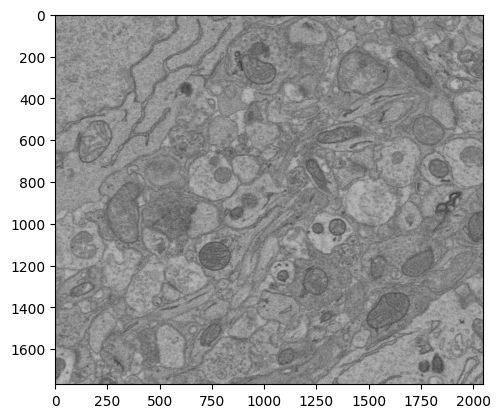

In [3]:
img = cv2.imread('./demo/denoise_demo.tif')
plt.imshow(img, cmap='gray')
crop_save_path = os.path.join('./demo', 'denoise_crop_patches', 'cell_1', 'noise_1')
os.makedirs(crop_save_path, exist_ok=True)
crop(img, crop_save_path, patch_size=256, overlap=0.125)

## Show Example Cropped Data

Text(0.5, 1.0, 'Example 2')

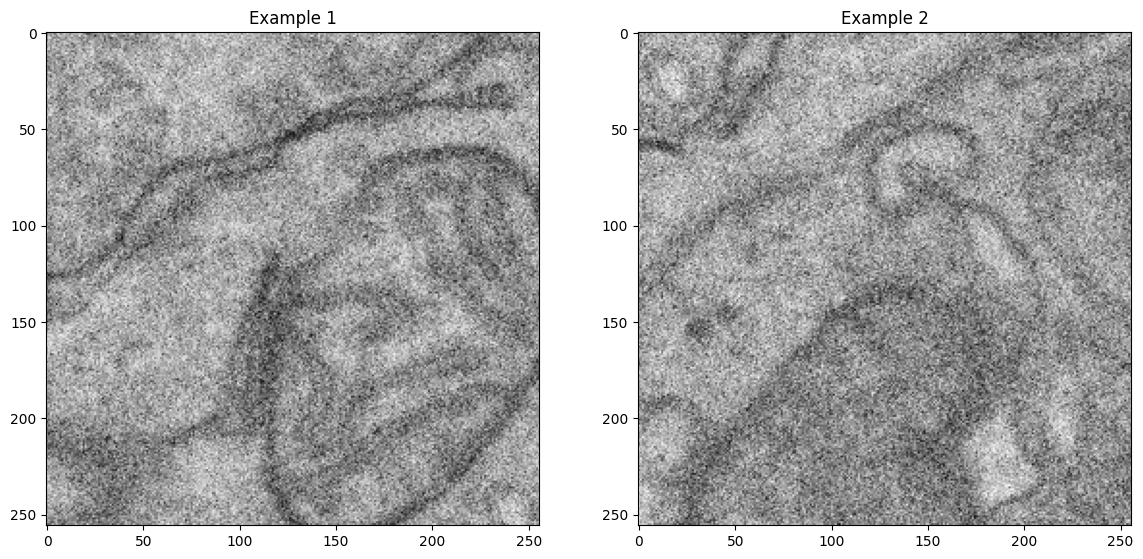

In [4]:
example_image_noise1 = imread(os.path.join(crop_save_path, '2_0.tif'))
example_image_noise2 = imread(os.path.join(crop_save_path, '3_1.tif'))
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(example_image_noise1, cmap='gray')
plt.title('Example 1')
plt.subplot(1,2,2)
plt.imshow(example_image_noise2, cmap='gray')
plt.title('Example 2')

## Download the Pretrained Model Weight

In [5]:
import urllib
import zipfile
if not os.path.isdir('./experiments'):
    os.mkdir('./experiments')

# Download the model weight trained on the mouse brain cortex denoise dataset. Skip this step if you prefer to use your own trained model.
zipPath="experiments/EMDiffuse-n.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://zenodo.org/records/10686030/files/EMDiffuse-n.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("experiments")

## EMDiffuse-n Model
Load the trained model (located in `experiments` with the name `EMDiffuse-n`) from disk.
When loading the model for testing, we replicate the training configuration with the addition of a few testing-specific parameters:

- batch size: test batch size.

- mean: Diffusion model samples one plausible solution from the learned solution distribution. Mean denotes the number of outputs you want to generate and average. 

- resume: The path to the model's weights file and the epoch number from which to load the model.
- step: The number of diffusion steps. More steps, higher image quality. 

In [13]:
os.chdir("/workspace/shared/repos/EMDiffuse")

In [14]:
config = EMDiffuseConfig(config='config/EMDiffuse-n.json', phase='test', 
                         path='./demo/denoise_crop_patches', batch_size=16, mean=1, resume='./experiments/EMDiffuse-n/best', step=200)
opt = Parser.parse(config) # Parse the config
opt['world_size'] = 1 
Util.set_seed(opt['seed'])
model = create_EMDiffuse(opt)
print(f'len test data loader: {len(model.phase_loader)}')

results and model will be saved in experiments/test_EMDiffuse-n_250424_132044
len test data loader: 4


/workspace/shared/repos/EMDiffuse/models/EMDiffuse_model.py:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(model_path, map_location=la

## Testing

The denoised images and logger information are automatically saved within a newly created directory as logged above. If you find the results are total noise image, it is mostly likely because you didn't load the model weight properly.

In [7]:
model.test()

sampling loop time step:  34%|███▍      | 69/200 [00:23<00:44,  2.97it/s]

sampling loop time step: 100%|██████████| 200/200 [00:04<00:00, 43.71it/s]


## Show Some Denoised Results 

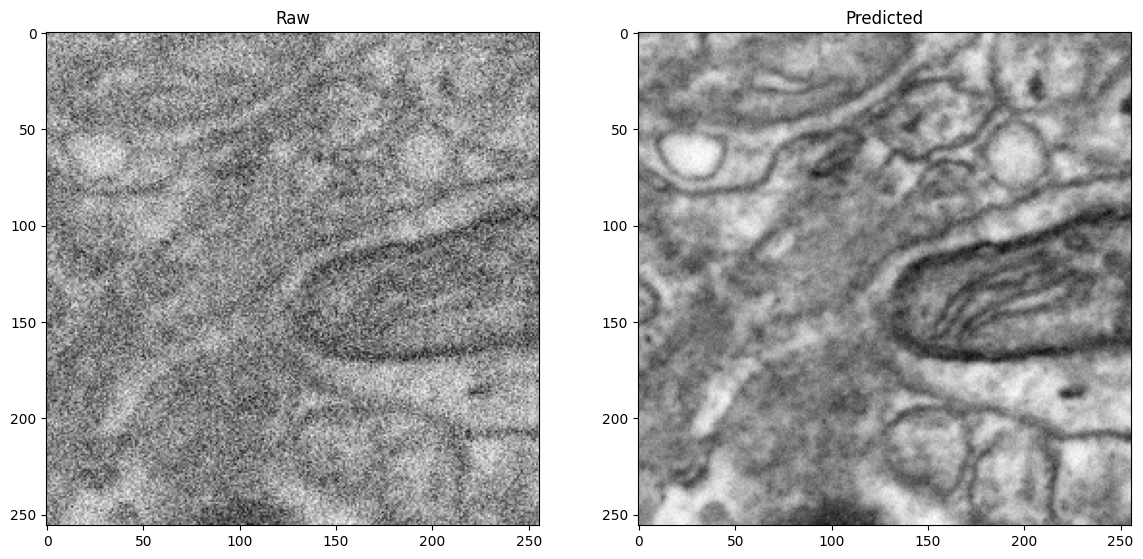

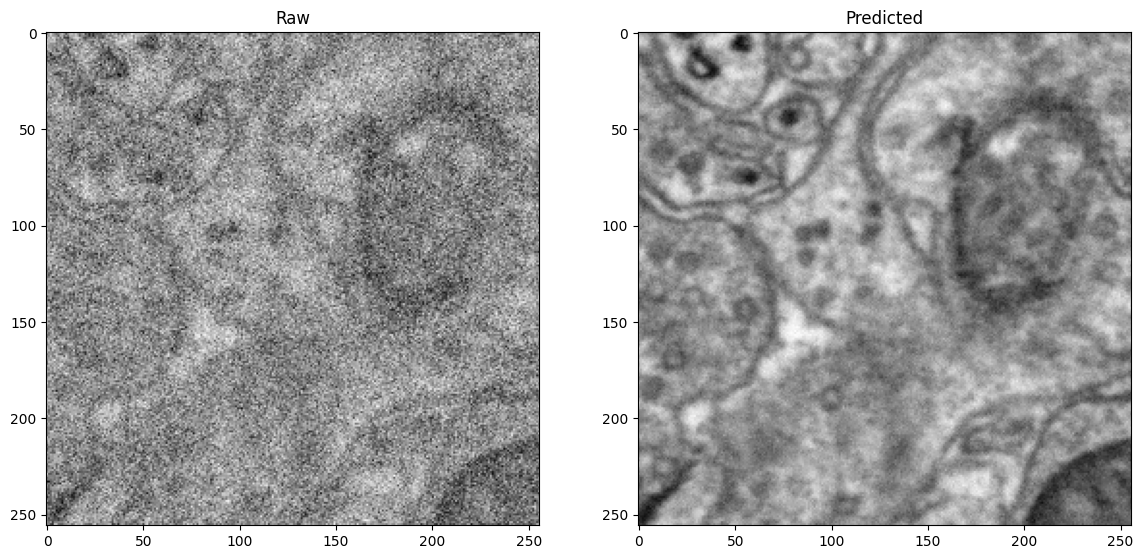

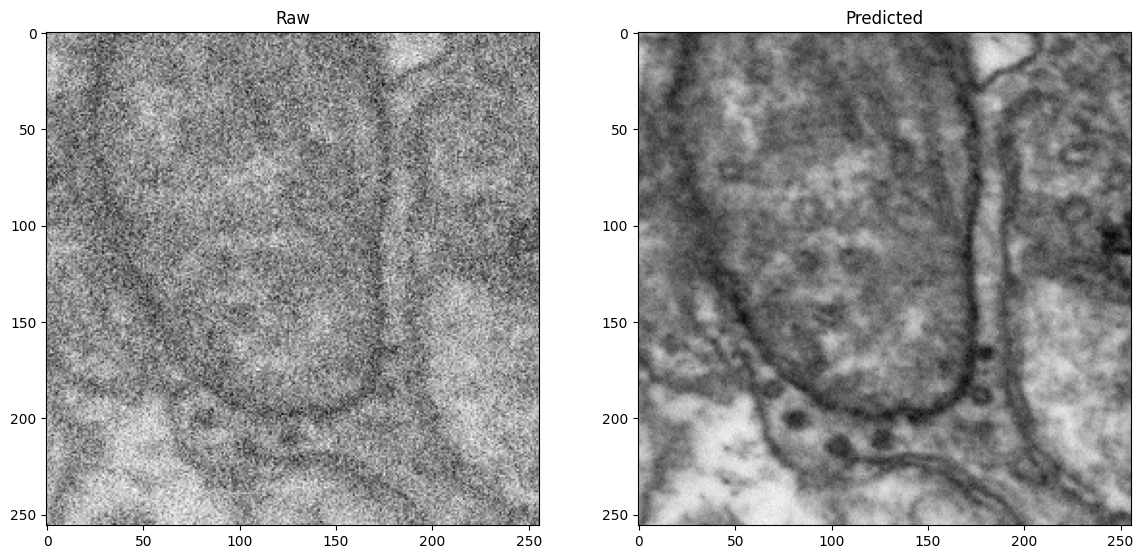

In [8]:
import glob
results_path = os.path.join(opt['path']['experiments_root'], 'results', 'test', '0')
noisy_images = glob.glob(os.path.join(results_path, 'Input_*.tif'))
if len(noisy_images) != 0:
    for i in range(3):
        noisy_img =  imread(noisy_images[i])
        denoised_img = imread(noisy_images[i].replace('Input', 'Out'))
        plt.figure(figsize=(14,7))
        plt.subplot(1,2,1)
        plt.imshow(noisy_img, cmap='gray')
        plt.title('Raw')
        plt.subplot(1,2,2)
        plt.imshow(denoised_img, cmap='gray')
        plt.title('Predicted')

# Test on our data

In [9]:
# 1) make sure zarr is installed
#    pip install zarr

import zarr, os
from crop_single_file import crop
from tifffile import imread, imwrite

# path to your Zarr “raw” dataset
zarr_path = '/workspace/ZARRs/APP-3M-SCN-SomaGT.zarr/raw'

# open it readonly
z = zarr.open(zarr_path, mode='r')
print("Zarr shape:", z.shape)  # → (Z, Y, X)

# where to dump patches
base_patch_dir = './demo/zarr_crops/APP-3M-SCN-SomaGT'
os.makedirs(base_patch_dir, exist_ok=True)

# 2) iterate over each slice
for zi in range(z.shape[0]):
    slice_img = z[zi, :, :]         # a (Y, X) numpy uint8
    out_dir = os.path.join(base_patch_dir, f'slice_{zi:03d}')
    os.makedirs(out_dir, exist_ok=True)
    # crop into 256×256 patches with 12.5% overlap
    crop(slice_img, out_dir, patch_size=256, overlap=0.125)

print("Done cropping all slices.")


Zarr shape: (300, 4500, 3000)


/opt/miniforge3/envs/emdiffuse/lib/python3.8/site-packages/tifffile/tifffile.py:2151: UserWarning: <tifffile.TiffWriter '0_14.tif'> writing zero-size array to nonconformant TIFF
  warnings.warn(
/opt/miniforge3/envs/emdiffuse/lib/python3.8/site-packages/tifffile/tifffile.py:2151: UserWarning: <tifffile.TiffWriter '0_15.tif'> writing zero-size array to nonconformant TIFF
  warnings.warn(
/opt/miniforge3/envs/emdiffuse/lib/python3.8/site-packages/tifffile/tifffile.py:2151: UserWarning: <tifffile.TiffWriter '0_16.tif'> writing zero-size array to nonconformant TIFF
  warnings.warn(
/opt/miniforge3/envs/emdiffuse/lib/python3.8/site-packages/tifffile/tifffile.py:2151: UserWarning: <tifffile.TiffWriter '0_17.tif'> writing zero-size array to nonconformant TIFF
  warnings.warn(
/opt/miniforge3/envs/emdiffuse/lib/python3.8/site-packages/tifffile/tifffile.py:2151: UserWarning: <tifffile.TiffWriter '0_18.tif'> writing zero-size array to nonconformant TIFF
  warnings.warn(
/opt/miniforge3/envs/emdi

Done cropping all slices.


In [20]:
import os, glob

# This needs to match the dataset loader’s expectation: 
# data_root/cell_num/noise_level/*.tif
base_patch_dir = './demo/zarr_crops/APP-3M-SCN-SomaGT'
for cell in os.listdir(base_patch_dir):
    cell_path = os.path.join(base_patch_dir, cell)
    if not os.path.isdir(cell_path):
        continue
    # Create a single “noise level” subfolder named "1"
    noise_dir = os.path.join(cell_path, '1')
    os.makedirs(noise_dir, exist_ok=True)
    # Move every .tif into that subfolder
    for tif in glob.glob(os.path.join(cell_path, '*.tif')):
        dest = os.path.join(noise_dir, os.path.basename(tif))
        os.rename(tif, dest)

print("✅ Patch folders reorganized:")
for cell in os.listdir(base_patch_dir):
    print(" ", cell, "→", os.listdir(os.path.join(base_patch_dir, cell)))


✅ Patch folders reorganized:
  slice_046 → ['1']
  slice_159 → ['1']
  slice_173 → ['1']
  slice_169 → ['1']
  slice_097 → ['1']
  slice_218 → ['1']
  slice_233 → ['1']
  slice_068 → ['1']
  slice_066 → ['1']
  slice_113 → ['1']
  slice_257 → ['1']
  slice_024 → ['1']
  slice_056 → ['1']
  slice_266 → ['1']
  slice_288 → ['1']
  slice_119 → ['1']
  slice_156 → ['1']
  slice_168 → ['1']
  slice_276 → ['1']
  slice_283 → ['1']
  slice_004 → ['1']
  slice_254 → ['1']
  slice_124 → ['1']
  slice_213 → ['1']
  slice_096 → ['1']
  slice_064 → ['1']
  slice_112 → ['1']
  slice_170 → ['1']
  slice_154 → ['1']
  slice_070 → ['1']
  slice_238 → ['1']
  slice_256 → ['1']
  slice_073 → ['1']
  slice_188 → ['1']
  slice_243 → ['1']
  slice_259 → ['1']
  slice_047 → ['1']
  slice_285 → ['1']
  slice_294 → ['1']
  slice_251 → ['1']
  slice_038 → ['1']
  slice_018 → ['1']
  slice_245 → ['1']
  slice_041 → ['1']
  slice_053 → ['1']
  slice_277 → ['1']
  slice_275 → ['1']
  slice_001 → ['1']
  slice_115

In [23]:
import os

# 2.1) Where you dumped your crops
base_patch_dir = './demo/zarr_crops/APP-3M-SCN-SomaGT'

# 2.2) For each slice folder, move all .tif into a subfolder named "1"
for slice_name in os.listdir(base_patch_dir):
    slice_path = os.path.join(base_patch_dir, slice_name)
    if not os.path.isdir(slice_path):
        continue
    noise_dir = os.path.join(slice_path, '1')
    os.makedirs(noise_dir, exist_ok=True)
    for fname in os.listdir(slice_path):
        src = os.path.join(slice_path, fname)
        dst = os.path.join(noise_dir, fname)
        # only move top-level TIFFs
        if os.path.isfile(src) and fname.endswith('.tif') and src != dst:
            os.rename(src, dst)

print("✅ Folder layout is now:")
print(os.listdir(base_patch_dir), "… each contains a '1' subfolder of TIFFs.")


✅ Folder layout is now:
['slice_046', 'slice_159', 'slice_173', 'slice_169', 'slice_097', 'slice_218', 'slice_233', 'slice_068', 'slice_066', 'slice_113', 'slice_257', 'slice_024', 'slice_056', 'slice_266', 'slice_288', 'slice_119', 'slice_156', 'slice_168', 'slice_276', 'slice_283', 'slice_004', 'slice_254', 'slice_124', 'slice_213', 'slice_096', 'slice_064', 'slice_112', 'slice_170', 'slice_154', 'slice_070', 'slice_238', 'slice_256', 'slice_073', 'slice_188', 'slice_243', 'slice_259', 'slice_047', 'slice_285', 'slice_294', 'slice_251', 'slice_038', 'slice_018', 'slice_245', 'slice_041', 'slice_053', 'slice_277', 'slice_275', 'slice_001', 'slice_115', 'slice_110', 'slice_081', 'slice_219', 'slice_106', 'slice_089', 'slice_040', 'slice_149', 'slice_092', 'slice_022', 'slice_284', 'slice_084', 'slice_031', 'slice_109', 'slice_133', 'slice_126', 'slice_071', 'slice_151', 'slice_129', 'slice_019', 'slice_227', 'slice_035', 'slice_269', 'slice_167', 'slice_065', 'slice_134', 'slice_174', 

In [ ]:
import os
from PIL import Image
import core.parser as Parser
import core.util as Util
from models import create_EMDiffuse
from emdiffuse_config import EMDiffuseConfig

# 2.1) Point at your cropped patches directory
base_patch_dir = './demo/zarr_crops/APP-3M-SCN-SomaGT'

# 2.2) Remove any zero‐byte or unreadable TIFFs so the dataloader won't choke
for root, _, files in os.walk(base_patch_dir):
    for fname in files:
        if not fname.lower().endswith('.tif'):
            continue
        path = os.path.join(root, fname)
        # delete zero‐length files
        if os.path.getsize(path) == 0:
            os.remove(path)
            continue
        # delete corrupted images
        try:
            with Image.open(path) as im:
                im.verify()
        except Exception:
            os.remove(path)

print("✅ Cleaned up bad TIFFs.")

In [32]:
## 2. Optimize & Denoise the Cropped TIFF Patches (single‐process loader)

import os
import torch.multiprocessing as mp
import core.parser as Parser
import core.util as Util
from models import create_EMDiffuse
from emdiffuse_config import EMDiffuseConfig

# 2.1) Force PyTorch to use filesystem‐based sharing (still useful for other ops)
mp.set_sharing_strategy('file_system')

# 2.2) Your crop folder
base_patch_dir = './demo/zarr_crops/APP-3M-SCN-SomaGT'

# 2.3) Build test‐time config
config = EMDiffuseConfig(
    config='config/EMDiffuse-n.json',
    phase='test',
    path=base_patch_dir,
    batch_size=64,    # try to fill GPU
    mean=1,
    resume='./experiments/EMDiffuse-n/best',
    step=200
)
opt = Parser.parse(config)
opt['world_size'] = 1
Util.set_seed(opt['seed'])

# 2.4) Override DataLoader args to use a single process
dargs = opt['datasets'][opt['phase']]['dataloader']['args']
dargs.update({
    'batch_size': 128,
    'num_workers': 0,      # <— disable workers to avoid /dev/shm bus errors
    'pin_memory': False,   # not needed when num_workers=0
})

print(f"Running with batch_size={dargs['batch_size']}, num_workers={dargs['num_workers']}")

# 2.5) Instantiate & run
model = create_EMDiffuse(opt)
print(f" → {len(model.phase_loader)} patch‐folders => {len(model.phase_loader)} batches")
model.test()
print("✅ Denoising complete.")


results and model will be saved in experiments/test_EMDiffuse-n_250424_134057
Running with batch_size=128, num_workers=0


/workspace/shared/repos/EMDiffuse/models/EMDiffuse_model.py:246: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(model_path, map_location=la

 → 624 patch‐folders => 624 batches


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:  44%|████▍     | 88/200 [03:55<05:00,  2.68s/it]


KeyboardInterrupt: 

In [33]:
# ─── Inspect dataset & batches ───
dloader = model.phase_loader
dataset_size = len(dloader.dataset)
bs = dloader.batch_size
num_batches = (dataset_size + bs - 1) // bs

print(f"Dataset size          : {dataset_size} items")
print(f"Batch size            : {bs}")
print(f"Total diffusion loops : {num_batches}")
print(f"Estimated total time  : {num_batches * 8.7:.1f} minutes (~{(num_batches*8.7)/60:.1f} hours)")


Dataset size          : 79800 items
Batch size            : 128
Total diffusion loops : 624
Estimated total time  : 5428.8 minutes (~90.5 hours)


In [ ]:
4992